In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import trefide.denoiser as denoiser

### Load 3D imaging data

Please note that, the lastest version of trefide, V2, is significantly revisioned to simplify function calls. The package structure is also adjusted to accomodate this revision. 

Before V2, the input data is of shape (X, Y, T). In V2, 4D data is supported and is the default. If your data is 3D, of shape (X, Y, T), you can append dummy Z (frame) axis to covert it to 4D data, like shape (X, Y, Z, Time). 

The input data is expected to be numpy array, which is row-major ordered. That means, if your data is saved from Matlab, which is column-major ordered, your data needs to be transposed to row-major ordered.


In [2]:
# 3D imaging data of shape (d1, d2, nchan, time)
Y = np.load('/mnt/data/3D_data/data_for_ding_apr17.npz')['Y_normalized']
Y = np.transpose(Y, [3,2,1,0])
# Note: the input data size needs to match 'bheight' & 'bwidth' parameter so that there will be whole blocks when 
# performing batch processing.
Y = np.ascontiguousarray(Y[:56,:128,:,:])
d1, d2, nchan, T = Y.shape
print(d1, d2, nchan, T)

56 128 3 27100


In [3]:
def eval_spatial_stat(u):
    tmp1 = np.abs(u[1:,:,:] - u[:-1,:,:])
    tmp2 = np.abs(u[:,1:,:] - u[:,:-1,:])
    tmp3 = np.abs(u[:,:,1:] - u[:,:,:-1])
    return (((np.sum(tmp1) + np.sum(tmp2) + np.sum(tmp3)) * np.prod(u.shape)) / 
            ((np.prod(tmp1.shape) + np.prod(tmp2.shape) + np.prod(tmp3.shape)) * np.sum(np.abs(u)))) 

def eval_temporal_stat(v):
    return np.sum(np.abs(v[:-2] + v[2:] - 2*v[1:-1])) / np.sum(np.abs(v))

In [4]:
# Specify Decomp Parameters
bheight = 14
bwidth = 16
hbheight = int(bheight/2)
hbwidth = int(bwidth/2)

# Specify Simulation Params
T = min(6000, T)
num_blocks = 16
num_comps = 3
num_samples = 240
num_repeats = int(num_samples / (num_blocks * num_comps))

# Iteratively Simulate & Fit Noise To Collect Samples
spatial_stats = []
temporal_stats = []
for rep in range(num_repeats):    
    # Generate Noise Movie Of NumSimul Blocks
    Y_sim = np.reshape(np.random.randn(num_blocks*bwidth*bheight*nchan*T),
                       (bheight, num_blocks*bwidth, nchan, T))

    # Run Denoiser W/ Max Comp 3 and absurdly large thresholds
    out = denoiser.batch_decompose(bheight, num_blocks*bwidth, nchan, T,
                                      Y_sim, bheight, bwidth,
                                      1e5, 1e5, 
                                      num_comps, 3, 10, 40, 5e-3)
    
    # Collect Test Statistics On All Samples
    for bdx in range(num_blocks):
        for cdx in range(num_comps):
            spatial_stats.append(eval_spatial_stat(out[0][bdx,cdx]))
            temporal_stats.append(eval_temporal_stat(out[1][bdx,cdx]))

spatial_stats = np.array(spatial_stats)
temporal_stats = np.array(temporal_stats)

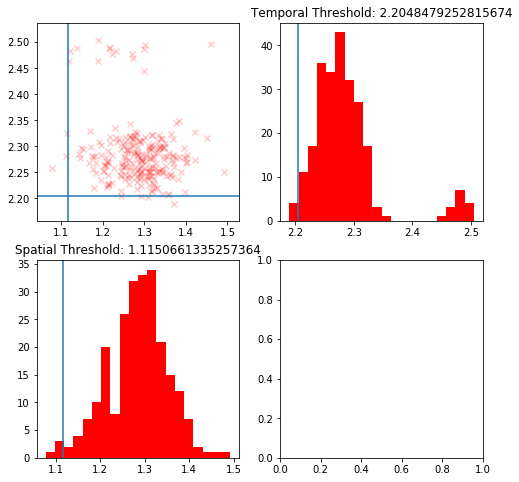

In [5]:
conf = .95
# Compute Thresholds
spatial_thresh =  np.percentile(spatial_stats, conf)
temporal_thresh = np.percentile(temporal_stats, conf)

fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].scatter(spatial_stats, temporal_stats, marker='x', c='r', alpha = .2)
ax[0,0].axvline(spatial_thresh)
ax[0,0].axhline(temporal_thresh)
ax[0,1].hist(temporal_stats, bins=20, color='r')
ax[0,1].axvline(temporal_thresh)
ax[0,1].set_title("Temporal Threshold: {}".format(temporal_thresh))
ax[1,0].hist(spatial_stats, bins=20, color='r')
ax[1,0].axvline(spatial_thresh)
ax[1,0].set_title("Spatial Threshold: {}".format(spatial_thresh))
plt.show()

In [6]:
max_comp = 30
temporal_thresh = 2.0

There are two sets of function call. We will use the overlapping set here. For more information, please checkout the docmentation denoiser webpage.

In [7]:
outs = denoiser.overlapping_batch_decompose(d1, d2, nchan, T,
                                   Y, bheight, bwidth,
                                   spatial_thresh, temporal_thresh,
                                   max_comp, 3, 40, 40, 5e-3)

In [8]:
Y_den = denoiser.overlapping_batch_recompose(outs, d1, d2, bheight, bwidth)
print(Y_den.shape)

(56, 128, 3, 6000)


In [9]:
def play_3d(movie, 
            gain=3, 
            fr=60, 
            offset=0, 
            magnification=1, 
            repeat=False):
    
    """ Render Video With OpenCV3 Library's Imshow"""
    d1, d2, nchan, T = movie.shape
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(T):
            if magnification != 1:
                frame = cv2.resize(np.reshape(movie[:,:,:,t], (d1, -1), order='F'),
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            else:
                frame = np.reshape(movie[:,:,:,t], (d1, -1), order='F')
            cv2.imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break
        looping=repeat

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

In [10]:
# display denoised imaging data
Y_denf = np.asfortranarray(Y_den)
play_3d(Y_denf, magnification=3, gain=1)

In [14]:
# display original imaging data
Y_f = np.asfortranarray(Y)
play_3d(Y_f, magnification=3)

In [15]:
# display background noise
Y_r = np.asfortranarray(Y_f[:,:,:,:T] - Y_denf)
play_3d(Y_r, magnification=3)

In [16]:
print(np.max(Y_r), np.min(Y_r))

15.531514968545501 -9.645262929041495


In [17]:
# display original, denoised, background noise imaging data for comparison
tmp = np.vstack([Y_f[:,:,:,:T], Y_denf, Y_r])
print(tmp.shape)
play_3d(tmp, magnification=3)

(168, 128, 3, 6000)


In [18]:
np.savez("./data_for_ding_apr17_denoised_notv.npz", Y_denoised=Y_denf, Y_original=Y_f)